In [1]:
## 設定GPU 可使用 nvidia-smi 查看GPU編號

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

!nvidia-smi

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4308217682213705625
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10001629184
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9883717190423126826
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]
Tue Dec 14 08:19:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 472.47       Driver Version: 472.47       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 

# Implementing the U-Net Architecture
The paper uses a U-Net architecture for doing the image inpainting. We've implemented this in `libs/unet.py` module, and we will review it here.

In [2]:
import gc
from copy import deepcopy
import cv2
import numpy as np

from keras.preprocessing.image import ImageDataGenerator

import matplotlib
import matplotlib.pyplot as plt

from libs.util import random_mask
from libs.pconv_model_bak import PConvUnet

# Settings
MAX_BATCH_SIZE = 128

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [4]:
# image_rows = 512
# image_cols = 768
image_cols = 512
image_rows = 768
weight_filepath = "./data/model/"

model = PConvUnet(img_rows=image_cols, img_cols=image_rows, weight_filepath=weight_filepath)
model.summary()

[DEBUG] vgg model
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, N

# Testing out on single image

[DEBUG] img(原始) (512, 768, 3) [[[116 116  88]
  [117 117  89]
  [120 120  92]
  ...
  [ 46  40  29]
  [ 46  40  29]
  [ 47  41  31]]

 [[122 119  92]
  [122 119  92]
  [123 120  93]
  ...
  [ 47  41  31]
  [ 47  41  31]
  [ 46  40  29]]

 [[126 123  94]
  [126 123  94]
  [127 124  95]
  ...
  [ 47  41  31]
  [ 46  40  29]
  [ 46  40  29]]

 ...

 [[ 61  85  32]
  [ 62  86  33]
  [ 65  89  36]
  ...
  [ 59  73  38]
  [ 51  64  32]
  [ 43  56  24]]

 [[ 61  85  29]
  [ 61  85  32]
  [ 62  86  33]
  ...
  [ 57  70  35]
  [ 48  62  27]
  [ 46  59  25]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
Shape of image is: (512, 768, 3)
[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


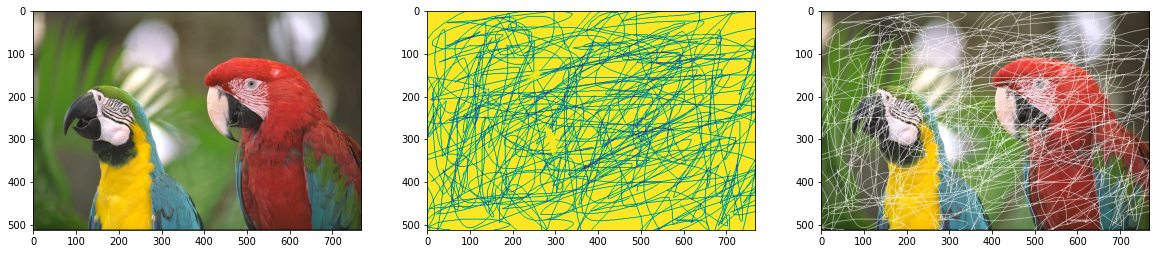

In [5]:
# Load image
img = cv2.imread('./data/kodim23.PNG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print("[DEBUG] img(原始)", img.shape, img)
img = cv2.resize(img, (image_cols, image_rows)) / 255
shape = img.shape
print(f"Shape of image is: {shape}")

# Load mask
# mask = random_mask(shape[0], shape[1])
mask = cv2.imread('./data/kodim23_mask.PNG')
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
mask = cv2.resize(mask, (image_cols, image_rows)) / 255
mask = 1-mask
print(mask)

# Image + mask
masked_img = deepcopy(img)
masked_img[mask==0] = 1

# Show side by side
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(img)
axes[1].imshow(mask*255)
axes[2].imshow(masked_img)
plt.show()

## Creating data generator
In this simple testing case we'll only be testing the architecture on a single image to see how it performs. We create a generator that will infinitely yield the same image and masked_image for us. The generator is based off the ImageDataGenerator from keras.processing, which allows us to do all kinds of autmentation more easily. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


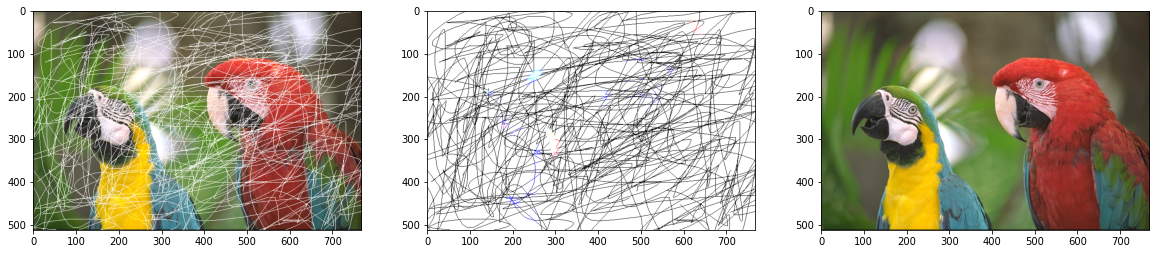

In [6]:
class DataGenerator(ImageDataGenerator):
    def flow(self, x, *args, **kwargs):
        while True:
            
            # Get augmentend image samples
            ori = next(super().flow(x, *args, **kwargs))

            # Get masks for each image sample
            _mask = cv2.imread('./data/kodim23_mask.PNG')
            _mask = cv2.cvtColor(_mask, cv2.COLOR_BGR2RGB)
            _mask = cv2.resize(_mask, (image_cols, image_rows)) / 255
            _mask = 1-_mask
            _mask = np.stack([_mask], axis=0)
            mask = _mask
            # print("[DEBUG] _mask", _mask.shape, _mask)
            # mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)
            # print("[DEBUG] mask", mask.shape, mask)
            

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori        

# Create datagen
datagen = DataGenerator(  
    rotation_range=0,
    width_shift_range=0,
    height_shift_range=0,
    horizontal_flip=True
)

# Create generator from numpy arrays
batch = np.stack([img for _ in range(MAX_BATCH_SIZE)], axis=0)
# print("[DEBUG] batch", type(batch), batch)
generator = datagen.flow(x=batch, batch_size=1)

# Get samples & Display them
(masked, mask), ori = next(generator)

# Show side by side
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(masked[0,:,:,:])
axes[1].imshow(mask[0,:,:,:]*255)
axes[2].imshow(ori[0,:,:,:])

## Training classifier on single image

In [7]:
def plot_callback(model):
    """Called at the end of each epoch, displaying our previous test images,
    as well as their masked predictions and saving them to disk"""
    
    # Get samples & Display them        
    pred_img = model.predict([masked, mask])

    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')                
        plt.show()

In [8]:
model.fit(
    generator, 
    steps_per_epoch=900,
    epochs=1,
    plot_callback=plot_callback,
)

Epoch 1/1
 12/900 [..............................] - ETA: 16:52 - loss: 1926943.2500

MemoryError: 

In [8]:
image_rows = 512
image_cols = 768
print(image_rows, image_cols, image_cols/image_rows)

512 768 1.5
